# Mod 4 Project - Jupyter Notebook

* Student name: **Dennis Trimarchi**
* Student pace: **Full time**
* Instructor name: **Rafael Carrasco**


This notebook contains an analysis of home sales price data broken down by zipcode for the Eastern Panhandle region of the **great state of West Virginina**. The WV panhandle itself contains three counties but the area of analysis includes neighboring counties in Virginia and Maryland. The data used in this project comes from the **zillow_data.csv** file included in this git repository.

# Import Libaries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools

import warnings
warnings.filterwarnings('ignore')

## Import My Functions from flatiron_time_series.py

In [2]:
from flatiron_time_series import get_SARIMA_parameters, run_SARIMAX
from flatiron_time_series import plot_prediction, get_forecast, plot_forecasts
from flatiron_time_series import pacf_plot, acf_plot

# Step 1: Load the Data/Filtering for Chosen Zipcodes

I am analyzing data for the WV Panhandle area - These 30 zipcodes are found in the Hagerstown and Winchester metro areas.

In [3]:
data = pd.read_csv('zillow_data.csv')
data = data[(data.Metro=='Winchester') 
            | (data.Metro=='Hagerstown') 
            | ((data.State=="WV") & (data.CountyName=="Jefferson"))]
print(data.shape)
data.head()

(30, 272)


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
189,67010,21740,Hagerstown,MD,Hagerstown,Washington,190,89700.0,89600.0,89500.0,...,148400,149500,150800,151500,151600,152200,154000,155900,157500,158400
2578,67012,21742,Hagerstown,MD,Hagerstown,Washington,2579,112100.0,112200.0,112300.0,...,194300,194800,194800,194600,193600,193300,195100,197800,200300,201700
3163,67322,22601,Winchester,VA,Winchester,Frederick,3164,98100.0,98000.0,97900.0,...,206300,208000,209800,210500,209900,209300,209400,209800,210800,211900
3771,67323,22602,Winchester,VA,Winchester,Frederick,3772,102200.0,102300.0,102200.0,...,224700,228900,233400,235900,237700,239600,240300,240800,242300,243400
5004,399559,25404,Martinsburg,WV,Hagerstown,Berkeley,5005,NaN,NaN,NaN,...,138900,139600,140400,142200,145000,148100,149200,149500,150900,152800


In [93]:
data.isna().sum().sum()

417

# Step 2: Data Preprocessing - Reshape to Wide Format

#### Create dataframe with each zipcode time series in its own column

In [4]:
def get_datetimes(df,start_col=1):
    return pd.to_datetime(df.columns.values[start_col:], format='%Y-%m')

In [5]:
panhandle_df = pd.DataFrame()
panhandle_df['Month'] = get_datetimes(data,7)

In [6]:
for zipcode in data.RegionName:
    row = data[data.RegionName==zipcode].iloc[:,7:]
    panhandle_df[zipcode] = row.values[0]
panhandle_df.set_index('Month',inplace=True)

In [7]:
print(panhandle_df.shape)
panhandle_df.head()

(265, 30)


,21740,21742,22601,22602,25404,22655,25414,25427,22603,25425,...,21722,22656,21782,22645,22625,21756,22624,22637,25442,21719
Month,,,,,,,,,,,,,,,,,,,,,
1996-04-01,89700.0,112100.0,98100.0,102200.0,NaN,101500.0,106500.0,NaN,104400.0,105500.0,...,102600.0,136100.0,96800.0,99500.0,NaN,122400.0,115000.0,93900.0,128600.0,84800.0
1996-05-01,89600.0,112200.0,98000.0,102300.0,NaN,101600.0,106300.0,NaN,104300.0,105300.0,...,102500.0,136200.0,96700.0,99500.0,NaN,122400.0,115100.0,93400.0,129000.0,84800.0
1996-06-01,89500.0,112300.0,97900.0,102200.0,NaN,101700.0,106300.0,NaN,104200.0,105200.0,...,102300.0,136200.0,96500.0,99500.0,NaN,122400.0,115100.0,92900.0,129400.0,84800.0
1996-07-01,89400.0,112500.0,97900.0,102100.0,NaN,101900.0,106200.0,NaN,104100.0,105000.0,...,102100.0,136200.0,96200.0,99400.0,NaN,122400.0,115100.0,92300.0,129800.0,84800.0
1996-08-01,89200.0,112700.0,97800.0,101900.0,NaN,101900.0,106300.0,NaN,104000.0,104900.0,...,101900.0,136100.0,95900.0,99300.0,NaN,122400.0,115100.0,91600.0,130300.0,84700.0


#### Summary DataFrame
Below creates a separate dataframe containing summary time series - total region and each state in the region

In [8]:
WV_zipcodes = list(data[data.State=='WV']['RegionName'])
MD_zipcodes = list(data[data.State=='MD']['RegionName'])
VA_zipcodes = list(data[data.State=='VA']['RegionName'])

In [9]:
#Make a dataframe that has some summary columns for the dataset - mean across region and by state
summary_df = pd.DataFrame()
summary_df['Region'] = panhandle_df.mean(axis=1)
summary_df['WV'] = panhandle_df[WV_zipcodes].mean(axis=1)
summary_df['MD'] = panhandle_df[MD_zipcodes].mean(axis=1)
summary_df['VA'] = panhandle_df[VA_zipcodes].mean(axis=1)

# Step 3: EDA and Visualization

In [126]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [105]:
plt.gcf().autofmt_xdate()

<Figure size 432x288 with 0 Axes>

Text(0, 0.5, '$')

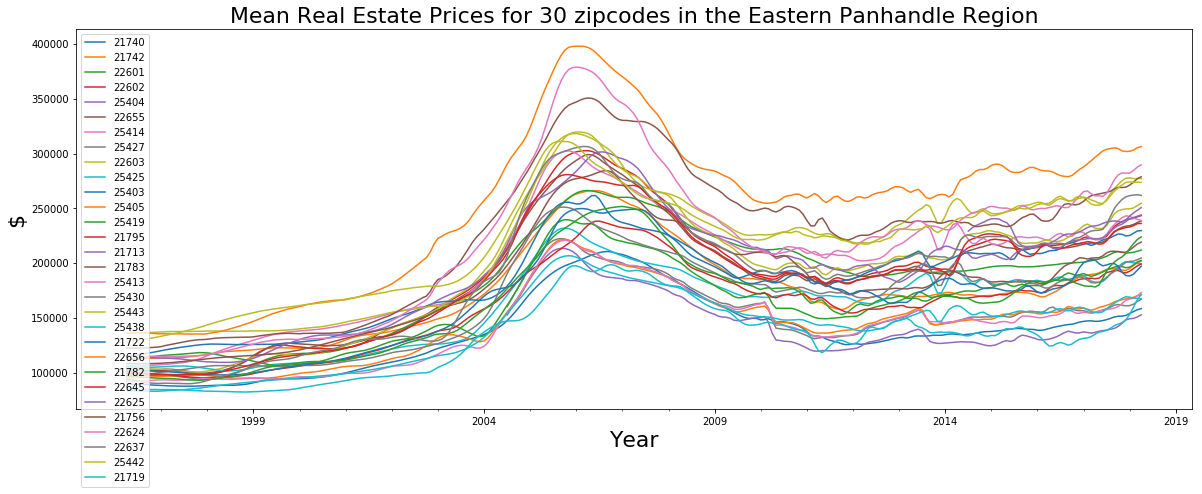

In [18]:
panhandle_df.plot(figsize=(20,7),legend=True)
plt.title("Mean Real Estate Prices for 30 zipcodes in the Eastern Panhandle Region",{'size':22});
plt.xlabel("Year",{'size':22})
plt.ylabel("$",{'size':22})

**The 2007 housing bubble crash is very apparent.**

Text(0, 0.5, '$')

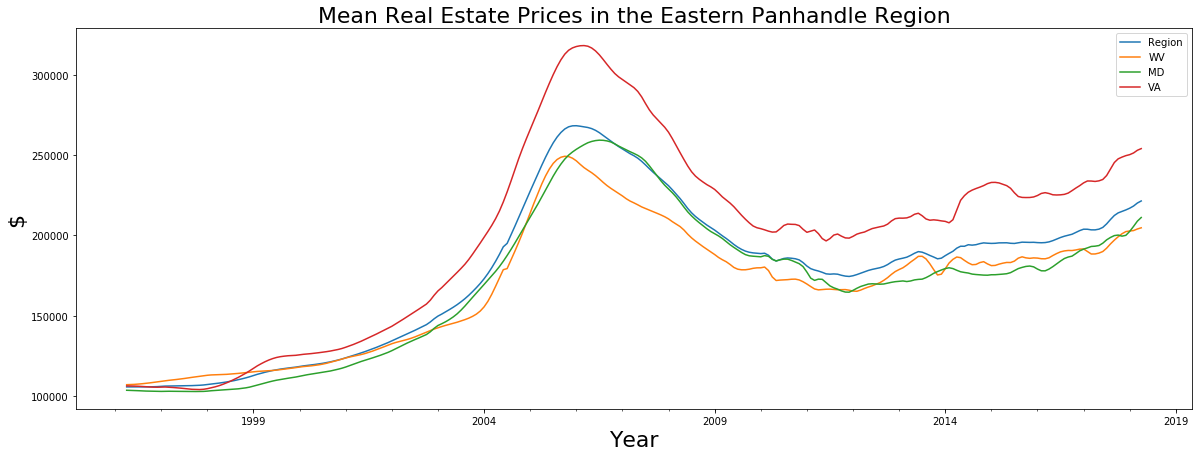

In [14]:
summary_df.plot(figsize=(20,7),legend=True)
plt.title("Mean Real Estate Prices in the Eastern Panhandle Region",{'size':22});
plt.xlabel("Year",{'size':22})
plt.ylabel("$",{'size':22})

### Seasonal Decomposition
Using statsmodels seasonal_decompose

In [35]:
decomposition = seasonal_decompose(np.log(summary_df))

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

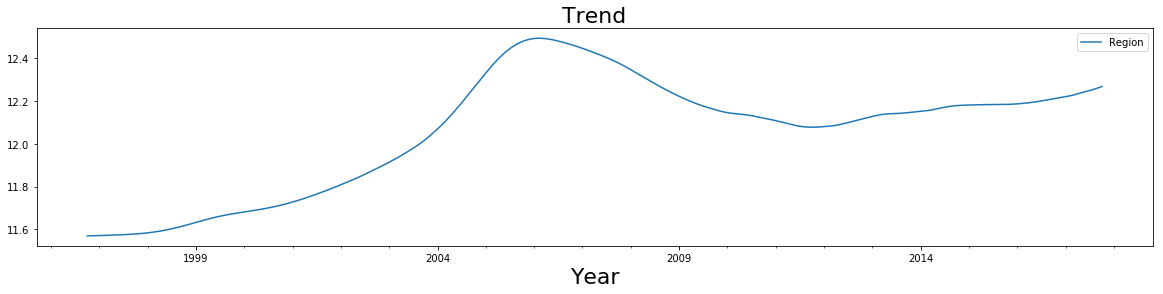

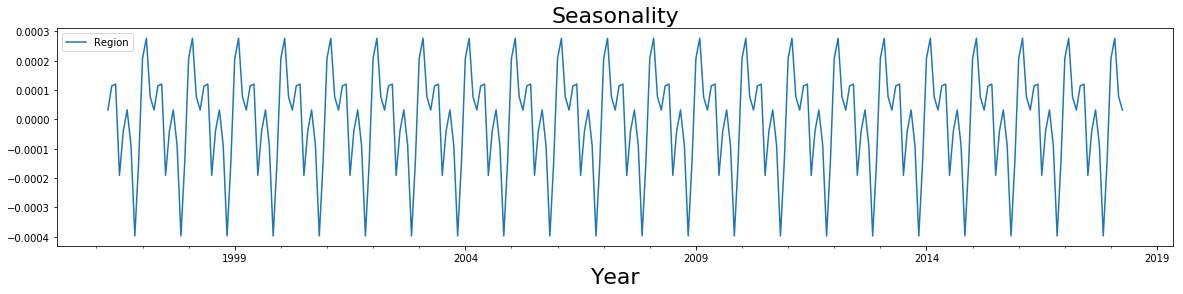

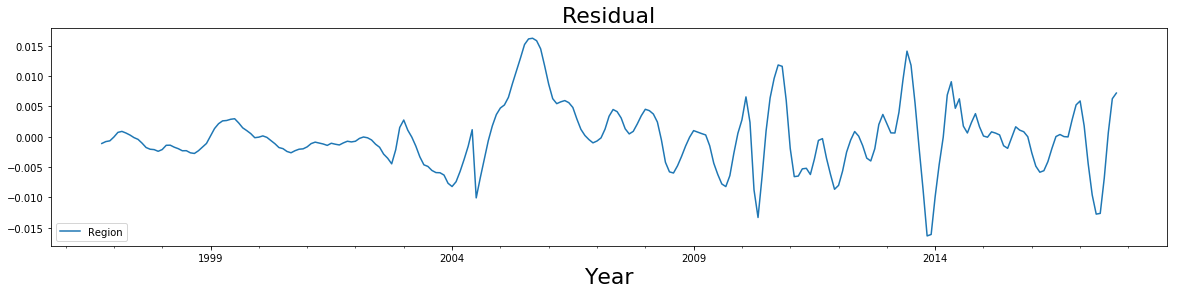

In [34]:
trend.Region.plot(figsize=(20,4),legend=True,title='Trend')
plt.title("Trend",{'size':22});
plt.xlabel("Year",{'size':22})
plt.show()

seasonal.Region.plot(figsize=(20,4),legend=True,title='Seasonality')
plt.title("Seasonality",{'size':22});
plt.xlabel("Year",{'size':22})
plt.show()

residual.Region.plot(figsize=(20,4),legend=True,title='Residual')
plt.title("Residual",{'size':22});
plt.xlabel("Year",{'size':22})
plt.legend(loc='lower left')
plt.show()

# Step 4: ARIMA Modeling

#### Train/Test Split

In [38]:
split_date = '2017-08'
training, validation = summary_df[:split_date].Region, summary_df[split_date:].Region
ts = summary_df.Region

### Testing different SARIMA Model parameters using Region average data

In [36]:
#ARIMA MODELING PARAMETERS
#Using s=12 because this is monthly data with yearly cycles although seasonality seems to be very minimal
p = [0,1,2,3]
d = [0,1]
q = [0,1,2,3]

sp = [0,1,2]
sd = [0,1]
sq = [0,1,2]
s = [12]

In [31]:
results = get_SARIMA_parameters(training,p,d,q,sp,sd,sq,s)
results[0:5]

total combos =  576


[{'terms': (1, 1, 3),
  'seasonal terms': (0, 1, 2, 12),
  'AIC': 3334.213220712779},
 {'terms': (1, 1, 3),
  'seasonal terms': (1, 1, 2, 12),
  'AIC': 3335.8853319028467},
 {'terms': (2, 1, 3),
  'seasonal terms': (0, 1, 2, 12),
  'AIC': 3336.2029158555106},
 {'terms': (3, 1, 3),
  'seasonal terms': (0, 1, 2, 12),
  'AIC': 3340.7008035893036},
 {'terms': (1, 1, 2),
  'seasonal terms': (0, 1, 2, 12),
  'AIC': 3346.8363587710646}]

### Make model using results of parameter tests

In [39]:
#pdq  = (1,1,3)
#pdqs = (0,1,2,12)

pdq   = (1,1,3)
pdqs  = (0,1,2,12)

model = run_SARIMAX(ts,pdq,pdqs)['model']
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             Region   No. Observations:                  265
Model:             SARIMAX(1, 1, 3)x(0, 1, 2, 12)   Log Likelihood               -1720.358
Date:                            Wed, 31 Jul 2019   AIC                           3454.715
Time:                                    16:54:00   BIC                           3478.597
Sample:                                04-01-1996   HQIC                          3464.355
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9653      0.020     48.627      0.000       0.926       1.004
ma.L1          0.1192      0.044      2.738      0.006       0.034       0.205
ma.L2         -0.0278      0.073     -0.381      0.703      -0.171       0.115
ma.L3         -0.0524      0.063     -0.837      0.403      -0.175       0.070
ma.S.L12      -1.1425      0.096    -11.922      0.000      -1.330      -0.955
ma.S.L24       0.1424      0.078      1.823      0.068      -0.011       0.296
sigma2      2.392e+05    4.4e-07   5.44e+11      0.000    2.39e+05    2.39e+05
===================================================================================
Ljung-Box (Q):                       26.48   Jarque-Bera (JB):              1039.01
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             0.84
Prob(H) (two-sided):                  0.95   Kurtosis:                        13.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.16e+26. Standard errors may be unstable.
"""

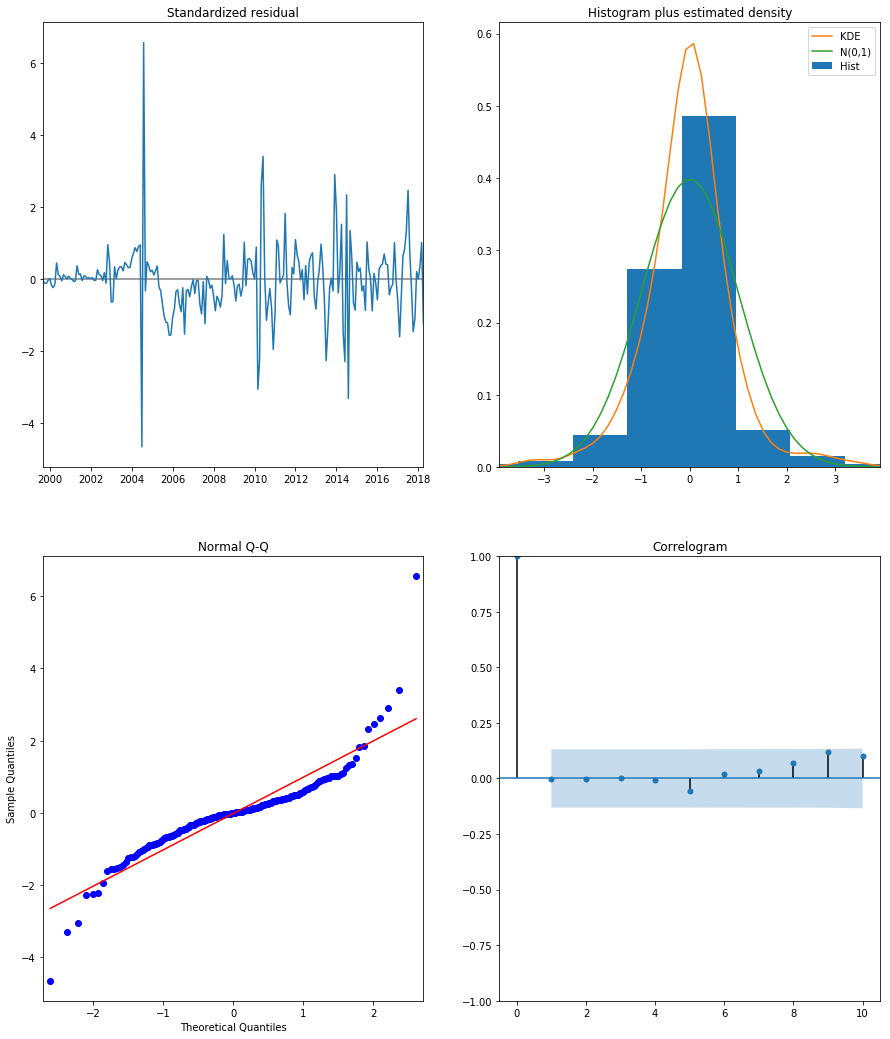

In [40]:
model.plot_diagnostics(figsize=(15,18));

## Checking ACF and PACF
I want to see if I my AR, MA terms are in line with these plots.

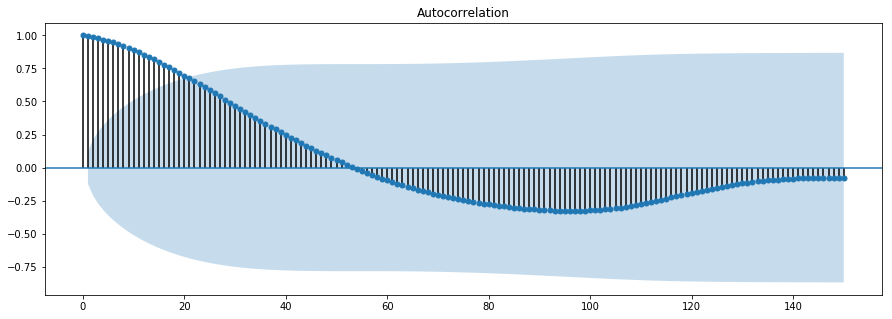

In [41]:
acf_plot(training,lags=150)

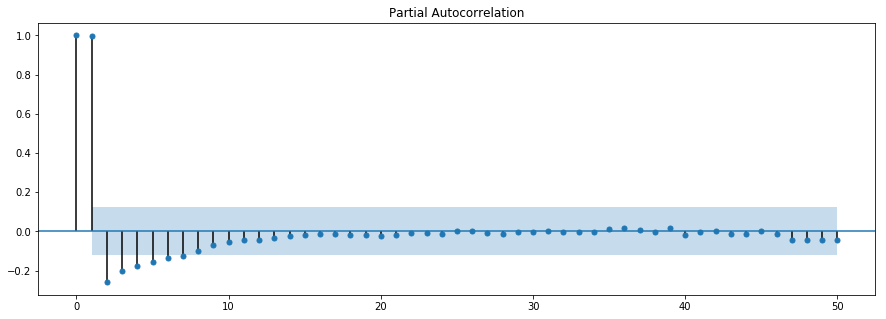

In [42]:
pacf_plot(training,lags=50)

## Making predictions using Model

### One-Step Ahead

RMSE:  532.2195808797809


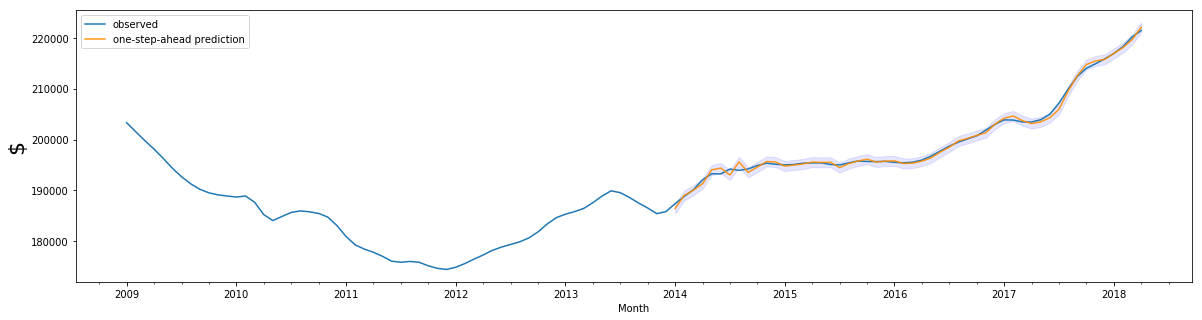

In [43]:
plot_prediction(ts['2009':],model,'2014', dynamic=False)
plt.ylabel('$',{'size':22});

### Dynamic

RMSE:  3862.582768161295


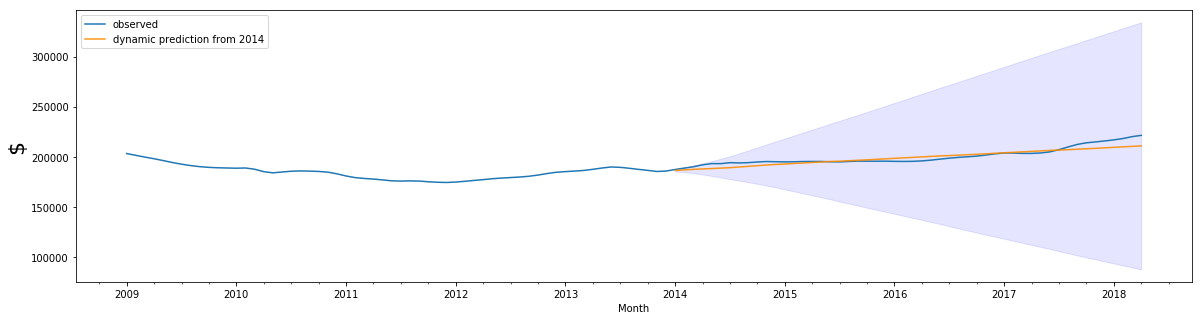

In [44]:
plot_prediction(ts['2009':],model,'2014',dynamic=True)
plt.ylabel('$',{'size':22});

### Forecast

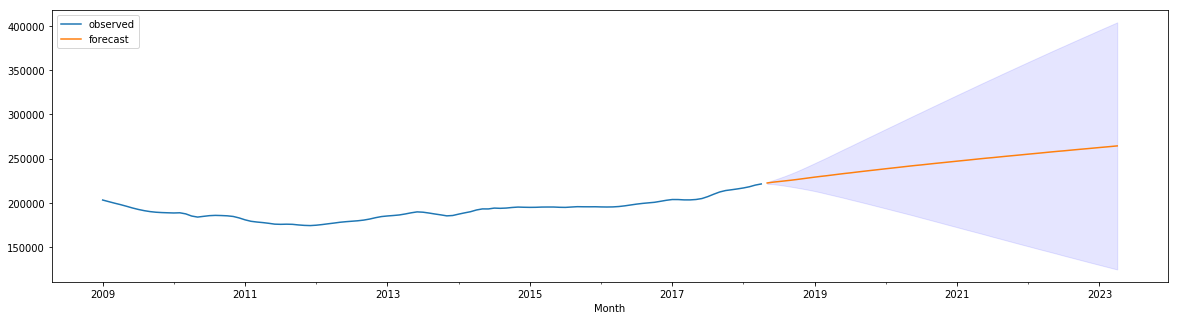

{'ROI_1yr': 0.046, 'ROI_5yr': 0.194}

In [45]:
get_forecast(ts['2009':],model,60,plot=True)

# Step 5: Apply Model & See Results

In [53]:
# Re-set different font sizes for plots
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

#### Run Model on each zipcode.
Populate list of dictionaries containing the results and each model in the form:

```
{'ROI_1yr': 0.000,
 'ROI_5yr': 0.000,
 'zipcode': 00000,
 'model': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1c61ec1828>,
 'city': 'city_name'}```

In [46]:
results = []

steps = 60

for zipcode in panhandle_df.columns:
    zipcode_model = run_SARIMAX(panhandle_df[zipcode].dropna(),pdq,pdqs)['model']
    if zipcode_model==None:
        continue
    result = get_forecast(panhandle_df[zipcode],zipcode_model,steps,plot=False)
    result['zipcode'] = zipcode
    result['model'] = zipcode_model
    location_info = data.loc[data.RegionName==zipcode,['City','State']].values
    label = f"{location_info[0][0]},{location_info[0][1]}"
    result['city'] = label
    results.append(result)
results = sorted(results,key=lambda x: x['ROI_5yr'],reverse=True)

In [47]:
results_df = pd.DataFrame(results)
results_df.drop(columns=['model'],inplace=True)
results_df.head()

,ROI_1yr,ROI_5yr,city,zipcode
0,0.053,0.299,"Martinsburg,WV",25404
1,0.052,0.273,"Keedysville,MD",21756
2,0.051,0.232,"Hagerstown,MD",21740
3,0.053,0.222,"Winchester,VA",22601
4,0.048,0.205,"Hagerstown,MD",21742


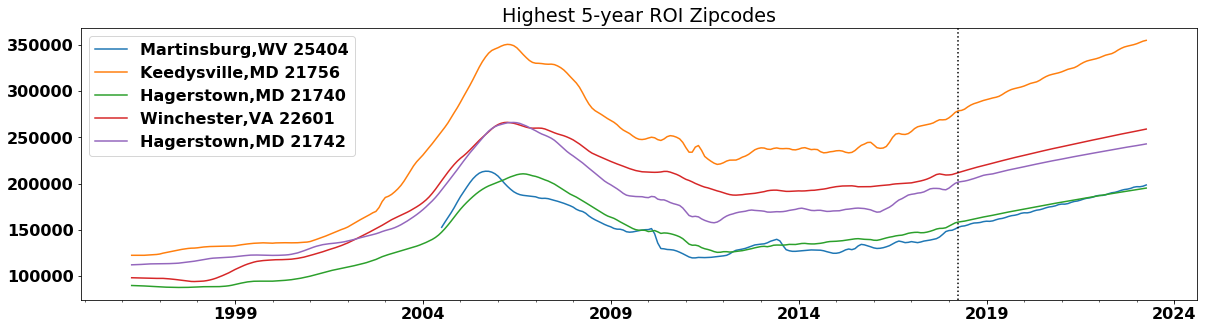

In [136]:
plot_forecasts(panhandle_df,sorted_results[0:5],steps=60,title='Highest 5-year ROI Zipcodes')

## Plots of Top 5 individually with confidence intervals

Martinsburg,WV


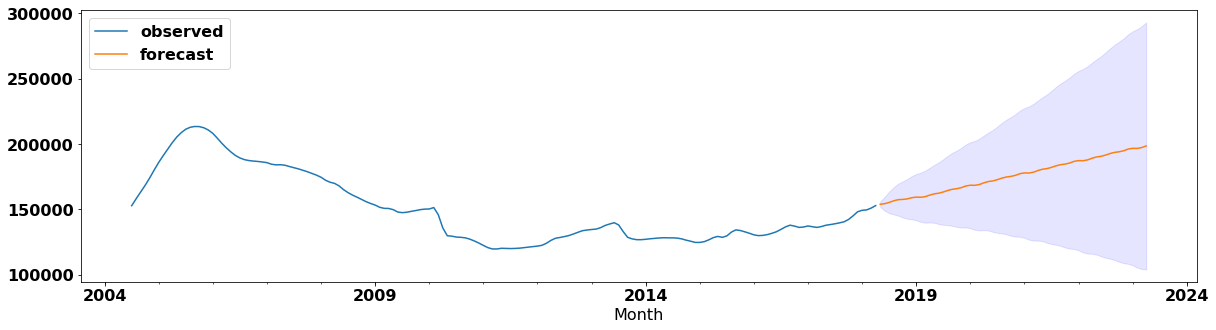

Keedysville,MD


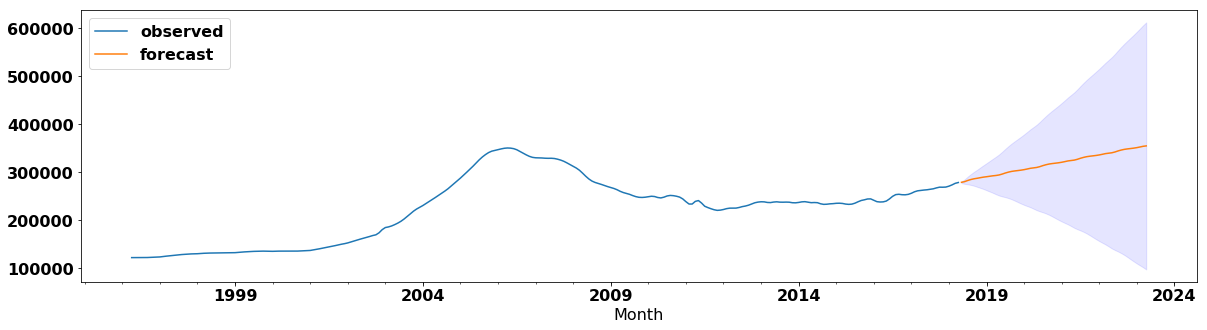

Hagerstown,MD


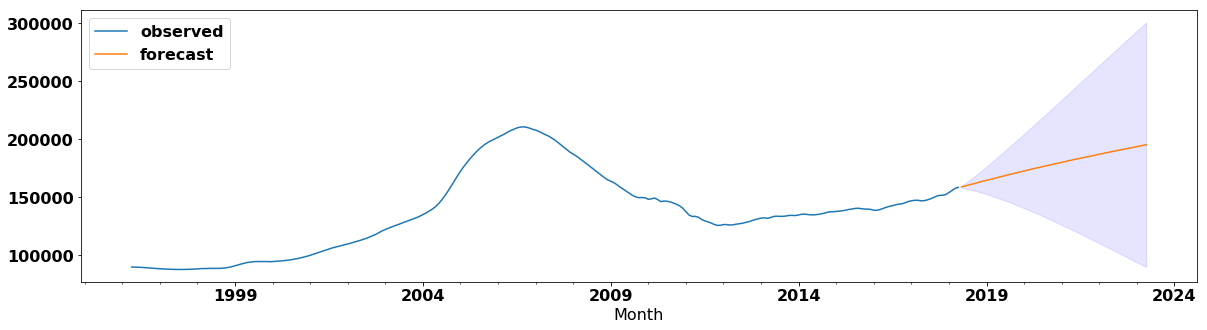

Winchester,VA


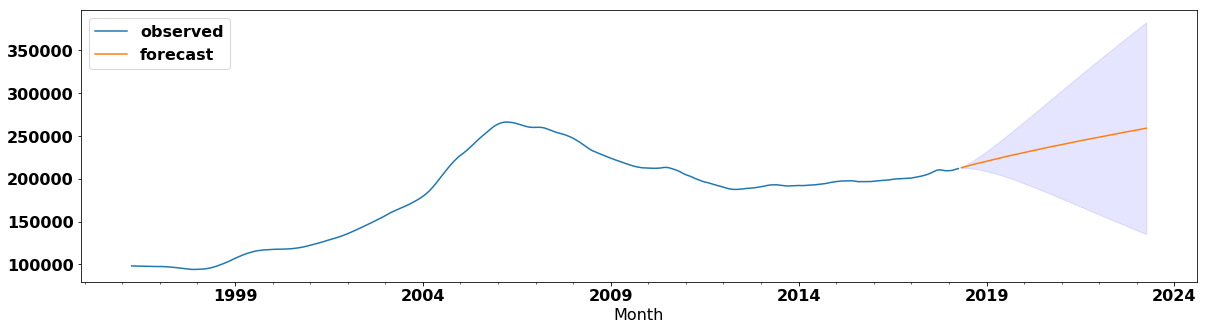

Hagerstown,MD


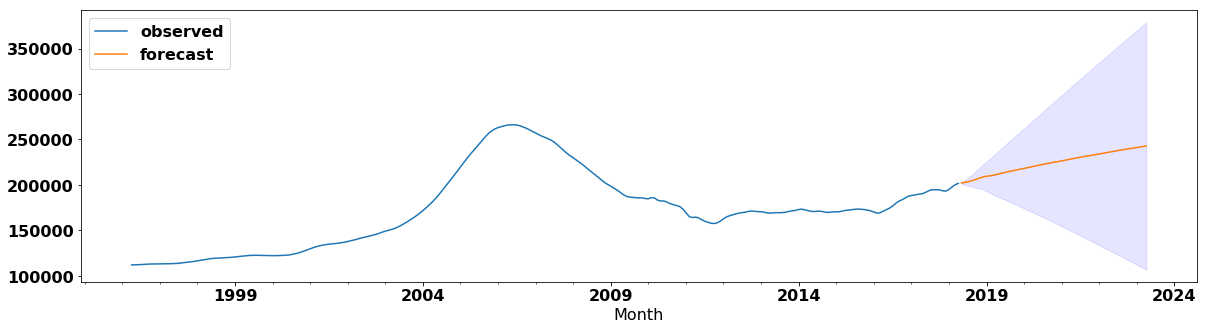

In [178]:
for result in results[0:5]:
    print(result['city'])
    get_forecast(panhandle_df[result['zipcode']],result['model'],60,plot=True)

In [159]:
results_df.tail()

,ROI_1yr,ROI_5yr,city,zipcode
24,-0.017,0.055,"Middletown,VA",22645
25,-0.025,0.049,"Shepherdstown,WV",25443
26,-0.027,0.042,"Harpers Ferry,WV",25425
27,-0.032,0.009,"Charles Town,WV",25414
28,-0.042,-0.007,"Kearneysville,WV",25442


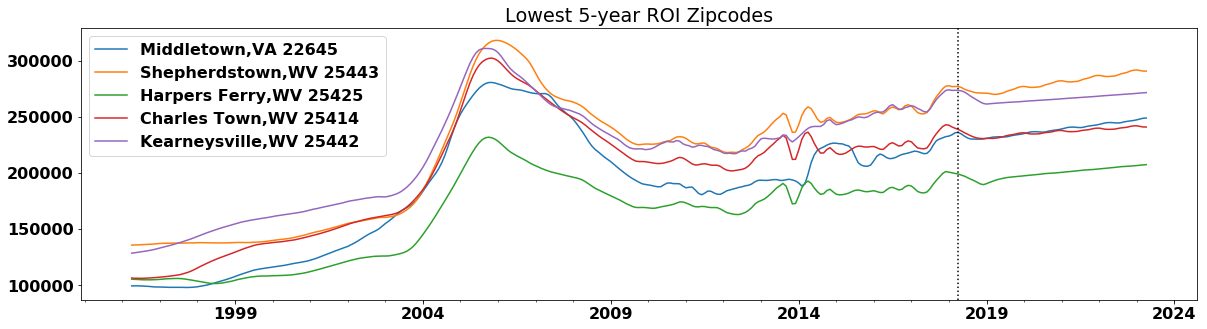

In [131]:
plot_forecasts(panhandle_df,sorted_results[-5:],steps=60,title='Lowest 5-year ROI Zipcodes')

In [220]:
sorted_results_1yr = sorted(results,key=lambda x: x['ROI_1yr'],reverse=True)
results_1yr_df = pd.DataFrame(sorted_results_1yr)
results_1yr_df.drop(columns=['model'],inplace=True)

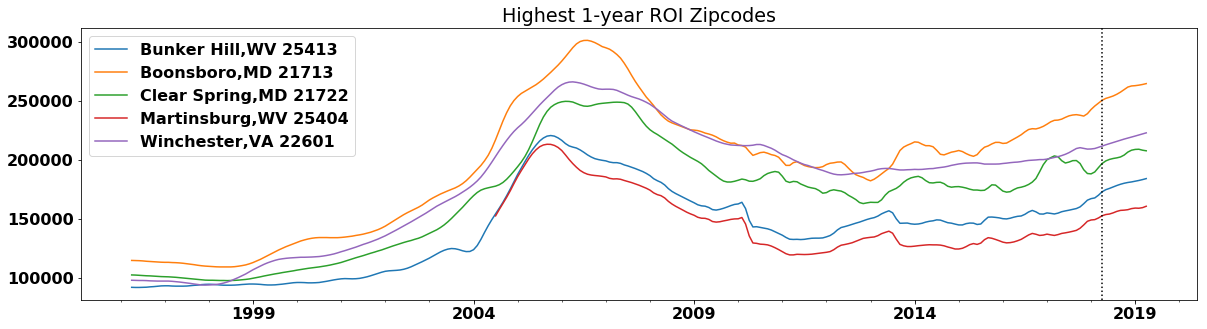

In [144]:
plot_forecasts(panhandle_df,sorted_results_1yr[0:5],steps=12,title='Highest 1-year ROI Zipcodes')

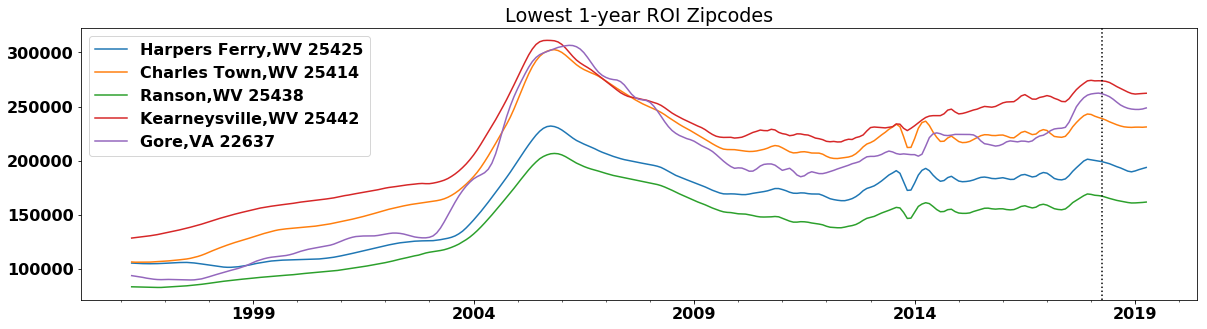

In [145]:
plot_forecasts(panhandle_df,sorted_results_1yr[-5:],steps=12,title='Lowest 1-year ROI Zipcodes')

## Checking differences between states

In [222]:
regional_results = []

steps = 60

#for region in summary_df.columns.difference(['Region']):
for region in summary_df.columns:
    regional_model = run_SARIMAX(summary_df[region].dropna(),pdq,pdqs)['model']
    if regional_model==None:
        continue
    result = get_forecast(summary_df[region],regional_model,steps,plot=False)
    result['city'] = " "
    result['zipcode'] = region
    result['model'] = regional_model
    regional_results.append(result)
regional_results = sorted(regional_results,key=lambda x: x['ROI_5yr'],reverse=True)

In [186]:
regional_results_df = pd.DataFrame(regional_results)
regional_results_df.drop(columns=['model','city'], inplace=True)
regional_results_df.rename(columns={'zipcode':'state'})

,ROI_1yr,ROI_5yr,state
0,0.056,0.260,MD
1,0.046,0.194,Region
2,0.014,0.139,VA
3,0.012,0.106,WV


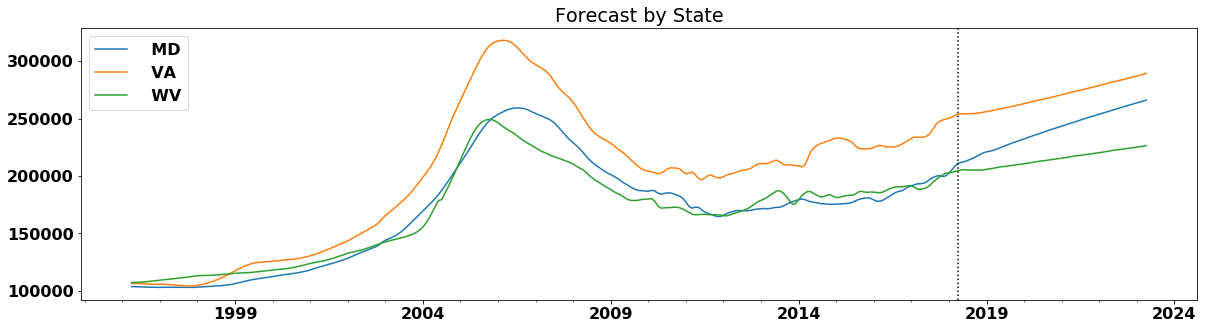

In [223]:
plot_forecasts(summary_df,regional_results,steps=60,title='Forecast by State')

# Facebook Prophet - Just playing around with this

In [294]:
from flatiron_fbprophet import get_ROI_FBprophet

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0.09010392505694546

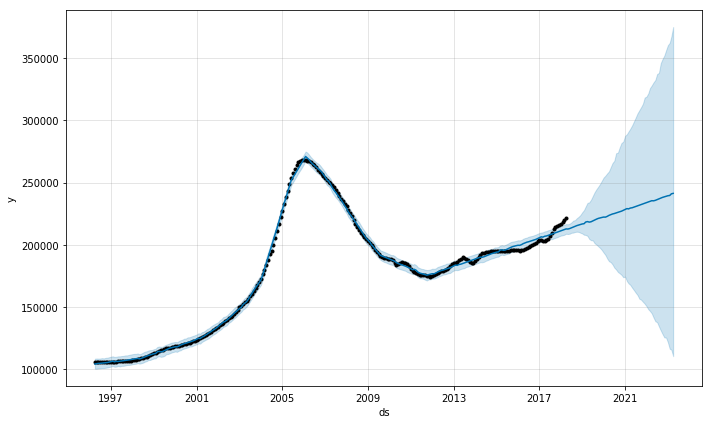

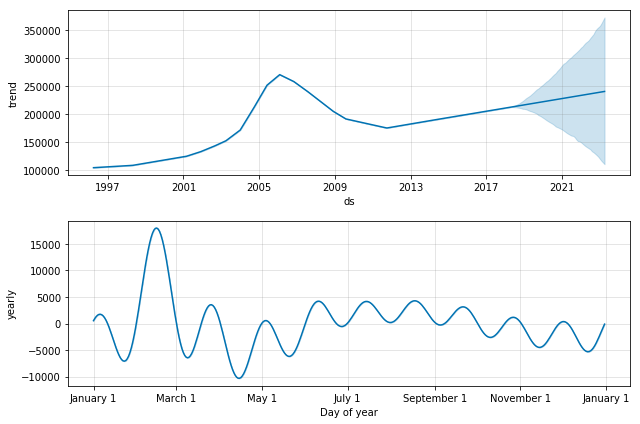

In [298]:
get_ROI_FBprophet(ts,periods=60,plot=True,plot_components=True)

In [354]:
prophet_results = []
for zipcode in panhandle_df.columns.difference(['Region']):
    roi = get_ROI_FBprophet(panhandle_df[zipcode].dropna(),periods=60,plot=False,plot_components=False)
    result = {'ROI_5yr': roi, 'zipcode':zipcode}
    location_info = data.loc[data.RegionName==zipcode,['City','State']].values
    label = f"{location_info[0][0]},{location_info[0][1]}"
    result['city'] = label
    prophet_results.append(result)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [355]:
prophet_sorted = sorted(prophet_results,key=lambda x: x['ROI_5yr'],reverse=True)
prophet_sorted[0:5]

[{'ROI_5yr': 0.5017314611077518,
  'zipcode': 22625,
  'city': 'Cross Junction,VA'},
 {'ROI_5yr': 0.15819033379295902, 'zipcode': 21713, 'city': 'Boonsboro,MD'},
 {'ROI_5yr': 0.15309108713230743,
  'zipcode': 25419,
  'city': 'Falling Waters,WV'},
 {'ROI_5yr': 0.147165930798213, 'zipcode': 25442, 'city': 'Kearneysville,WV'},
 {'ROI_5yr': 0.14218728894296487, 'zipcode': 21795, 'city': 'Williamsport,MD'}]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


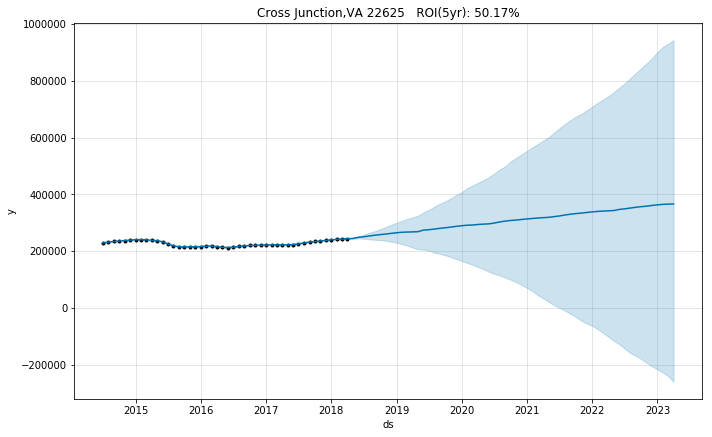

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


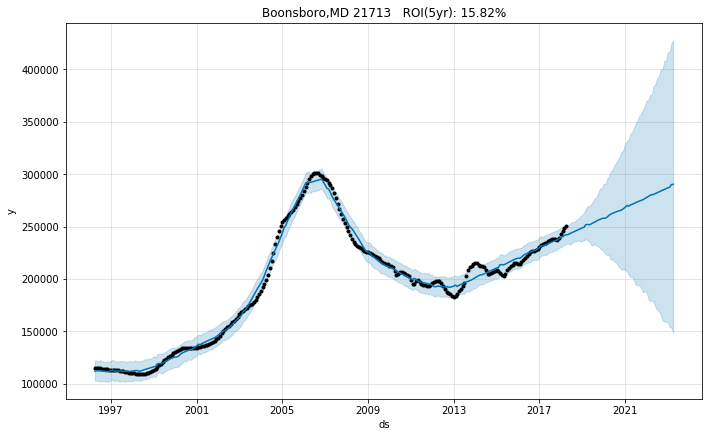

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


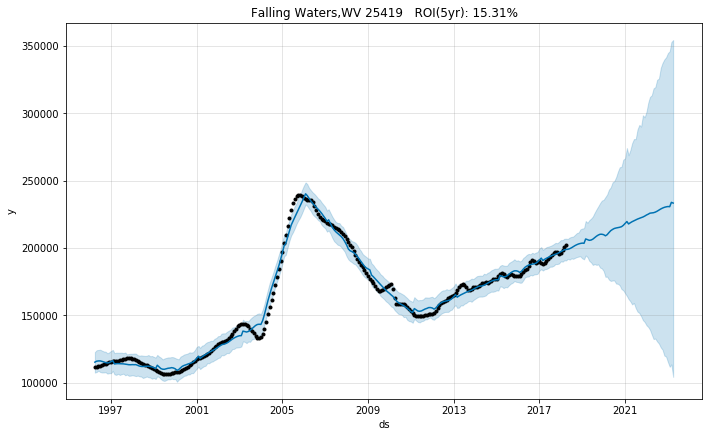

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


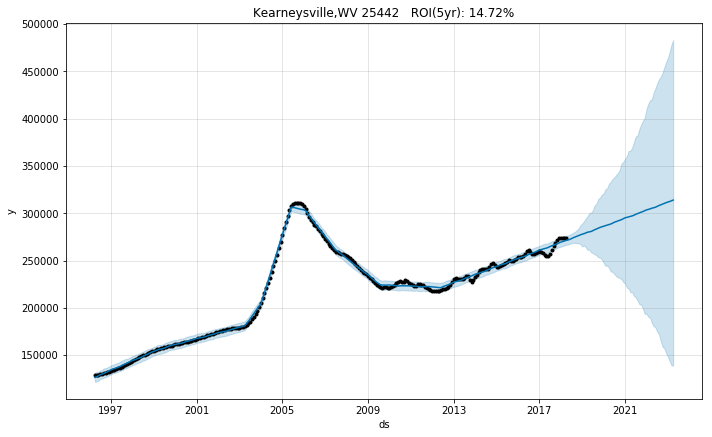

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


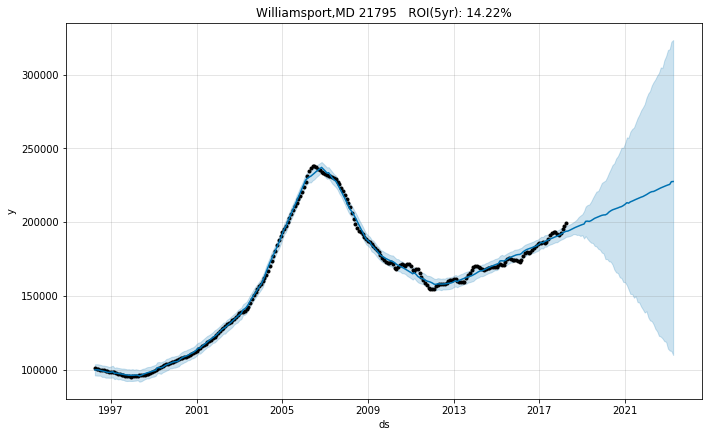

In [356]:
for item in prophet_sorted[0:5]:
    label = f"{item['city']} {item['zipcode']}   ROI(5yr): {item['ROI_5yr']:.2%}"
    get_ROI_FBprophet(panhandle_df[item['zipcode']].dropna(),periods=60,plot=True,plot_components=False,plot_title=label);